In [2]:
import random
import numpy as np 
from functools import reduce 
import typing
from copy import deepcopy
import matplotlib.pyplot as plt
from class_tree import *
from similarity import *
from transformation import *

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Combal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Combal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Combal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from datetime import datetime
dates = [
    '2006-10-28', '2005-11-15', '1936-11-07', '1955-09-08', '1936-12-07',
    '1937-04-12', '1974-12-02', '1972-06-30', '1955-07-06', '2006-09-09',
    '2007-11-06', '2007-11-13', '2009-09-29', '2014-03-25', '2001-12-04',
    '2004-09-06', '2004-11-10', '2004-11-23', '2004-12-09', '2005-09-27',
    '2011-09-27', '2000-09-12', '1999-09-14', '2003-11-11', '2004-02-05',
    '2006-04-04', '2005-11-16', '2005-11-24', '2008-09-23', '2010-10-19',
    '2005-09-13', '2005-09-14', '2006-03-07', '2009-09-08', '2011-11-01',
    '2003-06-03', '1969-02-10', '2017-04-28', '2022-10-24', '2004-05-10',
    '2018-03-14', '2002-04-11', '2013-03-09'
]

american_dates = []
european_dates = []

for date_str in dates:
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    american_date = date_obj.strftime('%m/%d/%Y - GMT+1:%H.%M.%S')
    american_dates.append(american_date)
    european_date = date_obj.strftime('%d/%m/%Y')
    european_dates.append(european_date)

# Print the converted dates
values_date = []
for a,e in zip(american_dates,european_dates):
    #print(a+" - "+e)
    values_date.append((a,e))

In [4]:
addresses = [
    '1234 Elm Street','567 Maple Avenue','789 Oak Drive','1011 Pine Lane','1213 Cedar Court','1415 Birch Road','1617 Willow Way','1819 Aspen Circle','2021 Juniper Street','2223 Spruce Avenue','2425 Alder Drive','2627 Chestnut Lane',
    '2829 Poplar Court','3031 Magnolia Road','3233 Laurel Way','3435 Acacia Circle','3637 Sycamore Street','3839 Hickory Avenue','4041 Pinecone Drive','4243 Cedar Lane','4445 Birch Court',
    '4647 Willow Road','4849 Aspen Way','5051 Juniper Avenue','5253 Spruce Drive','5455 Alder Court','5657 Chestnut Street','5859 Poplar Avenue','6061 Magnolia Lane','6263 Laurel Circle','6465 Acacia Road',
    '6667 Sycamore Way','6869 Hickory Court','7071 Pinecone Street','7273 Cedar Avenue','7475 Birch Drive','7677 Willow Lane','7879 Aspen Court','8081 Juniper Road','8283 Spruce Way',
    '8485 Alder Circle','8687 Chestnut Avenue','8889 Poplar Drive','9091 Magnolia Court','9293 Laurel Street','9495 Acacia Lane','9697 Sycamore Avenue','9899 Hickory Road','100101 Pinecone Way','102103 Cedar Court']

def add_noise(address):
    address_parts = address.split()
    for i in range(len(address_parts)):
        part = address_parts[i]
        if part.isdigit():
            # Modify the numbers by adding or subtracting a small random value
            num = int(part)
            noise = random.randint(-5, 5)
            address_parts[i] = str(num + noise)
        else:
            # Modify the names by randomly replacing a character with another
            modified_part = ''
            for char in part:
                if random.random() < 0.1:  # 10% chance of modification
                    modified_part += random.choice('abcdefghijklmnopqrstuvwxyz')
                else:
                    modified_part += char
            address_parts[i] = modified_part
    return ' '.join(address_parts)

noisy_addresses = [add_noise(address) for address in addresses]

# Print the converted dates
values_adress = []
for a,e in zip(noisy_addresses,addresses):
    #print(a+" - "+e)
    values_adress.append((a,e))

In [5]:
TRANSFORMATION_FUNCTIONS = transformation_functions()           
SIMILARITY_FUNCTIONS = similarity_functions()
           
flatten = lambda l : [item for sublist in l for item in sublist]
def get_rd_function(nb_child,value):
    if nb_child == 2:
        function_list = SIMILARITY_FUNCTIONS
    else:
        function_list = TRANSFORMATION_FUNCTIONS
    flag = True
    while flag:
        new_value = random.choice(function_list)
        if new_value != value:
            flag = False
    return new_value

In [13]:
class SimGen():
    def __init__(self, param_algo : dict , param_data : dict):
        #main param
        self.population_size : int = param_algo["population_size"]
        self.nb_generation   : int = param_algo["nb_generation"]
        self.threshold       : float = param_algo["threshold"]
        #candidate param
        self.tree_max_depth  : int = param_data["tree_max_depth"]
        #evolution param
        self.proba_selection : float = param_algo["proba_selection"]
        self.proba_mutation  : float = param_algo["proba_mutation"]
        self.proba_crossover : float = param_algo["proba_crossover"]
        self.selection_population_size   : int = round(self.proba_selection*self.population_size)
        self.mutation_population_size    : int = round(self.proba_mutation*self.population_size)
        self.crossover_population_size   : int = round(self.proba_crossover*self.population_size)
        self.random_tree_population_size : int = self.population_size - (
            self.mutation_population_size+
            self.crossover_population_size+
            self.selection_population_size
        ) #fill the population with random trees

        #init param
        #TODO implement diff types of population in evolution
        self.population : list[SimTree] = [] #current population
        self.population_candidate : list[SimTree] = [] #candidate population from which we will create the next population
        self.population_scores : list[int] = [0]*self.population_size #every candidate has a score computed at the end of an generation
        self.population_similarity : list[int] = [0]*self.population_size
        self.similarity_functions : list[rootType] = param_data["similarity_functions"] 
        self.transformation_functions : list[nodeType] = param_data["transformation_functions"]

        #values param
        self.values : list[tuple[str,str]] = param_data["values"] #[(x1,y1),(x2,y2)...,(xn,yn)] such as (ei,p,xi) <=> (e'i,p',yi)

        #meta param
        self.size_regularisation  = param_algo["size_regularisation"]
        self.gen_scores = []
        self.gen_top_k_scores = []
        self.top_k = param_algo["top_k"]

        self.size_tracker = []
        
    def generate_random_tree(self):
        nb_transformation = random.randint(1,self.tree_max_depth - 2)
        tf_left = np.random.choice(self.transformation_functions,nb_transformation,replace=False)
        tf_left = np.append(tf_left,["a"]) #TODO check comment mieux gerer le lift
        tf_right = np.random.choice(self.transformation_functions,nb_transformation,replace=False)
        tf_right = np.append(tf_right,["a"])
        sf = np.random.choice(self.similarity_functions,1)[0]
        def nest_list(lst):
            #format our list of function : [f,g,h,...]
            #into : [f,[g,[h,[...]]]]
            if len(lst) == 1:
                return [lst[0]]
            else:
                return [lst[0], nest_list(lst[1:])]

        tree_list = [sf,nest_list(tf_left),nest_list(tf_right)]
        tree = tree_from_list(tree_list)
        return tree

    def init_population(self):
        """
            Generate a population of size n with random tree
        
        """
        #check variance and stuff meta data TODO
        for _ in range(self.population_size):
            self.population.append(self.generate_random_tree())
    
    #TODO add regularisation parameter
    def fitness_over_population(self):
        '''
            Compute the score of a tree on every value pair
            Keep the mean as a score
        '''    
         
        for index,candidate in enumerate(self.population):
            sim_score = 0
            for values in self.values:
                #compute score for each value pair for one tree
                candidate.set_leafs_value(values)
                score = candidate.compute()
                sim_score += score
            sim_score /= len(self.values)
            #depth scoring
            min_depth = 3
            depth_score = (self.tree_max_depth - min_depth)/self.population[index].get_depth()
            
            self.population_scores[index] = sim_score - (self.size_regularisation*depth_score)
            self.population_similarity[index] = sim_score
            
            if self.population_scores[index] > 1:
                self.population_scores[index] = 1
            if self.population_scores[index] < 0:
                self.population_scores[index] = 0                                 
   
    def fitness_candidate(self,candidate : SimTree) -> int:
        sim_score = 0
        for values in self.values:
            #compute score for each value pair for one tree
            candidate.set_leafs_value(values)
            sim_score += candidate.compute()
            
        #TODO maybe use other metrics
        sim_score /= len(self.values)
        #depth scoring
        min_depth = 3
        depth_score = (self.tree_max_depth - min_depth)/candidate.get_depth()
        fitness_score = sim_score - (self.size_regularisation*depth_score)
        return fitness_score
       
    def tournament_selection(self):
        while len(self.population_candidate) < self.selection_population_size:
            c1,c2 = np.random.choice(self.population,2,replace=False)
            if self.fitness_candidate(c1) > self.fitness_candidate(c2):
                self.population_candidate.append(deepcopy(c1))
            else:
                self.population_candidate.append(deepcopy(c2))

    #TODO add loger to track evolution change
    def mutation(self):
        mutation_candidate = []
        while len(mutation_candidate) < self.mutation_population_size:
            mutation_candidate.append(np.random.choice(self.population_candidate,1)[0])
        
        for candidate in mutation_candidate:
            root_pointer = deepcopy(candidate)
            tree = root_pointer
            invalid_mutation = True
            
            while invalid_mutation:
                mutation_type = np.random.choice(["add","modify","remove"])
                if mutation_type =="remove":
                    #if condition not correct we loop because we cannot remove every transformation function
                    invalid_mutation = tree.child[0].get_depth() <= 2 and tree.child[1].get_depth() <= 2
                elif mutation_type == "add":
                    invalid_mutation = tree.child[0].get_depth() >= self.tree_max_depth - 2 and tree.child[1].get_depth() >= self.tree_max_depth - 2
                else:  #valid mutation
                    invalid_mutation = False
            match mutation_type:
                case "modify":
                    if np.random.choice(['root','nodes']) == 'nodes':
                        #print("change node")
                        tree = np.random.choice(tree.child) #choose left or right branche
                        max_depth = tree.get_depth() - 1 #minus leaf, 0 is current node, 1 is next node ... etc
                        depth_choice = np.random.choice(max_depth,1)[0]
                        while depth_choice > 0:
                            tree = tree.child[0]
                            depth_choice -=1
                        #depth_choice should be 0
                    #else:
                        #print("change root")
                    tree.value = get_rd_function(len(tree.child),tree.value)

                case "add":
                    child_choice = np.random.choice([0,1]) #choose left or right branche
                    if tree.child[0].get_depth() >= self.tree_max_depth - 1:
                        tree = tree.child[1]
                        child_choice = 1
                    elif tree.child[1].get_depth() >= self.tree_max_depth - 1:
                        tree = tree.child[0]
                        child_choice = 0
                    else:                
                        tree = tree.child[child_choice]
                    max_depth = tree.get_depth()
                    target_depth = np.random.choice(max_depth,1)[0]
                    #print("target_depth",target_depth)
                    #print("max depth", tree.get_depth())
                    before = 0 #we need to insert a node before the current one, i.e : a new node conected to the root
                    after  = 1 # we keep track of depths, we stop if we find our target depth
                    while before != target_depth and after != target_depth: #if after find target or before already is target
                        tree = tree.child[0]
                        after  += 1
                    #we found our target depth
                    #print(f"after : {after}, before {before}")
                    if before == target_depth: #we need to add a node connected to the root
                        _tmp = root_pointer.child[child_choice]
                        root_pointer.child[child_choice] = SimTree(get_rd_function(len(_tmp.child),None), [_tmp])
                    if after == target_depth: #we add a new node after the current
                        _tmp = tree.child[0]
                        tree.child[0] = SimTree(get_rd_function(len(_tmp.child),None),[_tmp])

                case "remove":
                    child_choice = np.random.choice([0,1]) #choose left or right branche
                    if tree.child[0].get_depth() <= 2:
                        tree = tree.child[1]
                        child_choice = 1
                    elif tree.child[1].get_depth() <=2:
                        tree = tree.child[0]
                        child_choice = 0
                    else:          
                        tree = deepcopy(tree.child[child_choice])

                    max_depth = tree.get_depth() - 1
                    target_depth = np.random.choice(max_depth,1)[0]
                    current_depth = target_depth
                    while current_depth != 0:
                        before_pointer = tree
                        tree = tree.child[0]
                        current_depth -=1
                        #we found our target depth
                        #print(f"target_depth : {target_depth}")
                        #link previous child we after child
                    if target_depth == 0:
                        root_pointer.child[child_choice] = deepcopy(tree.child[0])
                    else:
                        before_pointer.child[0] = deepcopy(tree.child[0])
            
            self.population_candidate.append(root_pointer) #append new created element

    def crossover(self):
        crossover_candidates = []
        while len(crossover_candidates) < self.crossover_population_size:
            crossover_candidates.append(np.random.choice(self.population_candidate,2))

        for t1,t2 in crossover_candidates:
            node_choice = [
                [deepcopy(t1.child[0]), deepcopy(t2.child[1])],
                [deepcopy(t2.child[0]), deepcopy(t1.child[1])],
            ]
            new_root_value = np.random.choice([t1.value,t2.value])
            new_tree = SimTree(new_root_value,node_choice[np.random.choice(2)])
            self.population_candidate.append(new_tree)

    def random_selection(self):
        random_trees = []
        while len(random_trees) < self.random_tree_population_size:
            random_trees.append(self.generate_random_tree())      

        self.population_candidate = np.append(self.population_candidate,random_trees)
           
    def save_state(self):
        pass

    def load_state(self):
        pass

    def stats(self):
        self.gen_scores.append(deepcopy(self.population_similarity))
        self.gen_top_k_scores.append(deepcopy(sorted(self.population_similarity,reverse=True)[:self.top_k]))
        self.size_tracker.append([t.get_depth() for t in self.population])

    def evolve_population(self, load= False):
        #compute score for each tree
        self.init_population()
        if load:
            self.load_state()
        for _ in range(self.nb_generation):
            if max(self.population_similarity) > self.threshold:
                break
            self.save_state()
            self.fitness_over_population()
            self.tournament_selection()
            self.crossover()
            self.mutation()
            self.random_selection()

            self.population = self.population_candidate
            self.population_candidate = []
            self.stats()
 

        self.fitness_over_population()
        self.stats()     



    #TODO create parent population 
        # select 

    #TODO add log to show trace of evolution for candidates

    #TODO add meta analyse de la taille des arbres et des types de fonctions utilisées
    #TODO maybe add constraint to force each operation to take new elem, (just check with index)
    #TODO table de hachage pour avoir la trace de chaque arbre ID unique pour l'historique des transformations


In [9]:
def plot_stats_sim(sim : SimGen, save = "") -> None:
    _fig = plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    pop_scores  = [np.mean(x) for x in sim.gen_scores]
    plt.plot(np.arange(0,len(pop_scores),1),pop_scores)

    top_k_scores  = [np.mean(x) for x in sim.gen_top_k_scores]
    plt.plot(np.arange(0,len(top_k_scores),1),top_k_scores)
    plt.subplot(1,2,2)
    size_avg  = [np.mean(x) for x in sim.size_tracker]
    plt.plot(np.arange(0,len(size_avg),1),size_avg)
    if save:
        plt.savefig(save)

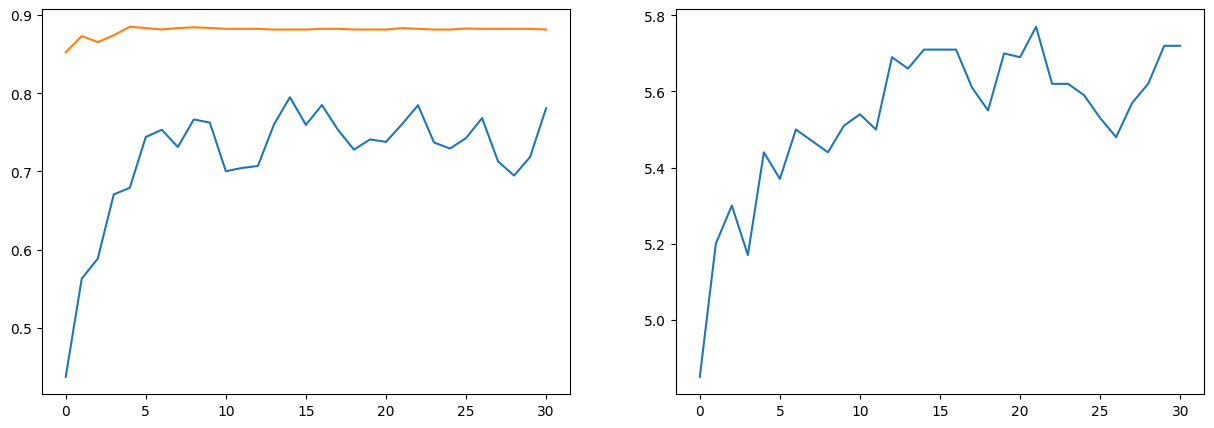

In [14]:
param_algo = {
    "population_size" : 100,
    "nb_generation"   : 30,
    "proba_selection" : 0.3,
    "proba_crossover" : 0.2,
    "proba_mutation"  : 0.3,
    "size_regularisation" : 0.5,
    "top_k" : 15,
    "threshold" : 0.95
}

param_data = {
    "tree_max_depth" : 6,
    "similarity_functions" : similarity_functions(),
    "transformation_functions" : transformation_functions(),
    "values" : values_adress
}


sim = SimGen(param_algo,param_data)
sim.evolve_population()
plot_stats_sim(sim)

In [59]:
mut = [0.2,0.3,0.4,0.5]
crossover = [0.4,0.3,0.2,0.1]
reg = [0.3,0.45,0.6,0.8]
for i in range(4):

    param_algo = {
        "population_size" : 100,
        "nb_generation"   : 30,
        "proba_mutation"  : mut[i],
        "proba_crossover" : crossover[i],
        "proba_random"    : 0.1,
        #"proba_ellitism"  : 0.4
        "size_regularisation" : reg[i],
        "top_k" : 15
    }

    param_data = {
        "tree_max_depth" : 5,
        "similarity_functions" : similarity_functions(),
        "transformation_functions" : transformation_functions(),
        "values" : values
    }


    sim = SimGen(param_algo,param_data)
    sim.evolve_population()
    plot_stats_sim(sim,str(i)+".png")


KeyboardInterrupt: 

In [19]:
(index := list(np.argsort(sim.population_similarity))).reverse()
for i in index:
    print(sim.population_scores[i],sim.population[i])


0.5818147016382311 ['jaro_similarity', ['remove_stopwords', ['tokenize', ['lowercase', '102100 Ceqar Court']]], ['tokenize', ['lowercase', ['remove_stopwords', '102103 Cedar Court']]]]
0.6316242254477548 ['jaro_similarity', ['remove_stopwords', ['remove_whitespace', ['remove_punctuation', ['remove_punctuation', '102100 Ceqar Court']]]], ['flatten', ['flatten', ['tokenize', ['tokenize', '102103 Cedar Court']]]]]
0.6316242254477548 ['jaro_similarity', ['remove_whitespace', ['remove_punctuation', ['remove_punctuation', '102100 Ceqar Court']]], ['strip_whitespace', ['flatten', ['remove_punctuation', ['tokenize', '102103 Cedar Court']]]]]
0.6316242254477548 ['jaro_similarity', ['remove_stopwords', ['remove_whitespace', ['remove_punctuation', ['remove_punctuation', '102100 Ceqar Court']]]], ['flatten', ['remove_punctuation', ['tokenize', '102103 Cedar Court']]]]
0.6316242254477548 ['jaro_similarity', ['remove_whitespace', ['remove_punctuation', ['remove_punctuation', '102100 Ceqar Court']]],

In [10]:
print_pop = list(map(lambda x: str(x),sim.population))

In [11]:
###---------------------------------------------------------------------###
###-------------------------------------> Helper functions

def f(a : str) -> str:
    return a+"o"
def g(a : str) -> str:
    return a+"K"
def h(a : str) -> str:
    return a+a
def ag1(a : str, b : str) -> str:
    return a+"-"+b
def ag2(a : str, b : str) -> str:
    return b+"-"+a



In [12]:
a = [ag1,
        [g,"a"],
        [f,["b"]]
    ]
b = [ag1, [f, 'a'], [g, 'a']]
t1 = tree_from_list(b)
print(t1.child[0].get_depth())
print(t1.child[1].get_depth())
root_pointer = deepcopy(t1)
tree = root_pointer
if np.random.choice(['root','nodes']) == 'nodes':
    #print("change node")
    tree = np.random.choice(tree.child) #choose left or right branche
    max_depth = tree.get_depth() - 1 #minus leaf, 0 is current node, 1 is next node ... etc
    depth_choice = np.random.choice(max_depth,1)[0]
    while depth_choice > 0:
        tree = tree.child[0]
        depth_choice -=1
    #depth_choice should be 0
#else:
    #print("change root")
tree.value = get_rd_function(len(tree.child),tree.value)
print(root_pointer)

2
2
['jaccard_similarity', ['f', 'a'], ['g', 'a']]
